In [44]:
%cd drive/MyDrive/thesis
%ls

[Errno 2] No such file or directory: 'drive/MyDrive/thesis'
/content/drive/MyDrive/thesis
cc.zh.300.bin  cmn-yue-wuu-wen-parallel-simplified.csv  sgns.merge.char


In [45]:
from difflib import ndiff
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from statistics import stdev, mean, median
import seaborn as sns

In [46]:
a = "这个苹果很酸"
b = "搿只苹果老酸个"

In [47]:
for d in ndiff(b, a):
  print(d[0], d[2])

- 搿
- 只
+ 这
+ 个
  苹
  果
- 老
+ 很
  酸
- 个


In [48]:
from numpy import delete
# the class to caculate the edit distance, takes two strings as arguments
# return edit distances, edit detailed (deletion, addition and substitution and remain)
# and edit details for the strings (what strings got deleted, added or substituded )
# the normalized distance get is the opposite of similarity

class edit_distance():
  def __init__(self, str1, str2):
    self.each_edit_details = [(s[0], s[2]) for s in ndiff(str1, str2)]
    self.strings_len = len(str1)+len(str2)

  def get_distance(self):
    # get normalized distance of two strings(divided by the total length of two strings)
    edit = {"+":0, "-":0}
    distance = 0
    for edit_code, *_ in self.each_edit_details:
        #if edit_code == " ": # same character, so no edits
            #distance += edit["+"] + edit["-"]
            #edit["+"] = 0
            #edit["-"] = 0
        if edit_code == "+" or edit_code == "-": 
            edit[edit_code] += 1
    distance += edit["+"]+edit["-"]
    return distance/self.strings_len  
  
  def get_each_edit(self):
    edits = self.each_edit_details
    subs, delete, add, noedit = [],[],[],[]
    i = 0
    while i < len(edits):
      current = edits[i]
      #print("current:", i, current)
      if current[0] == "-":
        minus, plus = [], []
        if i == len(edits)-1:
          i += 1
        j = i
        while j < len(edits)-1:
          j += 1
          next = edits[j]
          if next[0] == " ":
            i = j
            break
          else:
            if next[0] == "+":
              plus.append(next)
              i = j + 1
            if len(plus)==0 and next[0] == "-":
              minus.append(next)
              i = j + 1
            if len(plus)!=0 and next[0] == "-":
              i = j
              break
        if len(plus)==0:  # no + before " " or - is the last one
          delete.append(current[1])
          for m in minus:
            delete.append(m[1])
        else:
          minus_str = current[1] + "".join([m[1] for m in minus])
          plus_str  = "".join([p[1] for p in plus])
          subs.append((minus_str, plus_str))
          
      elif current[0] == "+":
        minus, plus = [], []
        if i == len(edits)-1:
          i += 1
        j = i
        while j < len(edits)-1:
          j += 1
          next = edits[j]
          if next[0] == " ":
            i = j
            break
          else:
            if next[0] == "-":
              i = j + 1
              minus.append(next)
            if len(minus)==0 and next[0] == "+":
              plus.append(next)
              i = j + 1
            if len(minus)!=0 and next[0] == "+":
              i = j
              break
          #i = j+1
        if len(minus)==0:  # no - before " " or + is the last one
          add.append(current[1])
          for p in plus:
            add.append(p[1])
        else:
          minus_str = "".join([m[1] for m in minus])
          plus_str  = current[1] + "".join([p[1] for p in plus])
          subs.append((minus_str, plus_str))

      else:
        noedit.append(current[1])
        i += 1

    return {"deletion":delete, "addition": add, "substitution":subs, "noedit":noedit}


In [49]:
edit = edit_distance("你应该先和你的父母谈谈", "侬应该跟㑚爷娘谈清爽先")
edit.get_distance(), edit.each_edit_details

(0.7272727272727273,
 [('-', '你'),
  ('+', '侬'),
  (' ', '应'),
  (' ', '该'),
  ('+', '跟'),
  ('+', '㑚'),
  ('+', '爷'),
  ('+', '娘'),
  ('+', '谈'),
  ('+', '清'),
  ('+', '爽'),
  (' ', '先'),
  ('-', '和'),
  ('-', '你'),
  ('-', '的'),
  ('-', '父'),
  ('-', '母'),
  ('-', '谈'),
  ('-', '谈')])

In [50]:
edit.get_each_edit()

{'deletion': ['和', '你', '的', '父', '母', '谈', '谈'],
 'addition': ['跟', '㑚', '爷', '娘', '谈', '清', '爽'],
 'substitution': [('你', '侬')],
 'noedit': ['应', '该', '先']}

#### Get all the data and start analysis

In [51]:
data_all = pd.read_csv("cmn-yue-wuu-wen-parallel-simplified.csv", encoding="utf-8")
cmn = data_all["cmn_sentence"]
wuu = data_all["wuu_sentence"]
yue = data_all["yue_sentence"]
wen = data_all["wen_sentence"]
wen[0]

'卬你试试眙！'

In [52]:
### punctuations and numbers are removed
def get_all_distances(lang1, lang2):
  sentence_edits = {}
  punc = ["。", "，", "！", "？", "'", "\"", ",", ".", "、", "?", "「", "」"]
  num = "0123456789" 
  for i in range(len(lang1)):
    #print(i, lang1[i], lang2[i])
    str1 = "".join([t.strip() for t in lang1[i] if t not in punc and t not in num])
    str2 = "".join([t.strip() for t in lang2[i] if t not in punc and t not in num])
    edit = edit_distance(str1, str2)
    sentence_edits[i] = {"sent1":str1, "sent2":str2, "distance":edit.get_distance(), "each_edit":edit.get_each_edit(), "edit_details":edit.each_edit_details}
  return sentence_edits

In [53]:
###get sum, largest and average of the edit distance of two languages
def distance_analytical(sentence_edits):
  sum, average, largest = 0, 0, 0
  largest_sents = 0
  all_distances = []
  all_del, all_add = [], []
  all_subs, all_same = [], []
  for i, edit in enumerate(sentence_edits):
    distance = sentence_edits[i]["distance"]
    each_edit = sentence_edits[i]["each_edit"]
    edit_details = sentence_edits[i]["edit_details"]

    sum += distance
    if distance > largest:
      largest = distance
      largest_sents = {i:(sentence_edits[i]["sent1"], sentence_edits[i]["sent2"])}
    
    all_distances.append(distance)

    deletion = each_edit["deletion"]
    add      = each_edit["addition"]
    subs     = each_edit["substitution"]
    same     = each_edit["noedit"]
    all_del += deletion
    all_add += add
    all_subs += subs
    all_same += same

  average = sum / len(sentence_edits)
  edit_details = {"all_del":all_del, "all_add":all_add,"all_subs":all_subs, "all_noEdits":all_same}
  return {"all_distances": all_distances,"distance_sum":sum, "distance_largest":(largest, largest_sents), "distance_average":average, "each_edit_details": edit_details}

##### Mandarin and Shanghainese

In [54]:
cmn_wuu = get_all_distances(cmn, wuu)
cmn_wuu[12]

{'sent1': '你应该先和你的父母谈谈',
 'sent2': '侬应该跟㑚爷娘谈清爽先',
 'distance': 0.7272727272727273,
 'each_edit': {'deletion': ['和', '你', '的', '父', '母', '谈', '谈'],
  'addition': ['跟', '㑚', '爷', '娘', '谈', '清', '爽'],
  'substitution': [('你', '侬')],
  'noedit': ['应', '该', '先']},
 'edit_details': [('-', '你'),
  ('+', '侬'),
  (' ', '应'),
  (' ', '该'),
  ('+', '跟'),
  ('+', '㑚'),
  ('+', '爷'),
  ('+', '娘'),
  ('+', '谈'),
  ('+', '清'),
  ('+', '爽'),
  (' ', '先'),
  ('-', '和'),
  ('-', '你'),
  ('-', '的'),
  ('-', '父'),
  ('-', '母'),
  ('-', '谈'),
  ('-', '谈')]}

In [55]:
cmn_wuu_distance = distance_analytical(cmn_wuu)
distances = cmn_wuu_distance["all_distances"]
sum = cmn_wuu_distance["distance_sum"]
largest = cmn_wuu_distance["distance_largest"]
average = cmn_wuu_distance["distance_average"]
edit_details = cmn_wuu_distance["each_edit_details"]
sum, largest, average, #distances

(65.41215569594104, (1.0, {1: ('那又怎样', '哏末哪能呢')}), 0.467229683542436)

In [56]:
edit_details.keys()
#edit_details["all_del"], edit_details["all_add"], edit_details["all_noEdits"]
edit_details["all_subs"], 

([('我们', '阿拉'),
  ('那又怎样', '哏末哪能呢'),
  ('不', '侬勿'),
  ('说废话', '瞎讲'),
  ('这个', '搿只'),
  ('很', '老'),
  ('别', '勿要'),
  ('了', '记脱'),
  ('天六时', '朝点钟'),
  ('接', '寻'),
  ('他', '伊'),
  ('什么时候', '啥辰光'),
  ('你', '侬'),
  ('不', '勿'),
  ('你', '脱侬'),
  ('把这块', '拿搿只'),
  ('表', '錶'),
  ('给你', '拨侬'),
  ('这些', '搿眼是啥人个'),
  ('这', '搿'),
  ('不', '勿'),
  ('什么时候都', '啥个辰光侪'),
  ('的', '个'),
  ('都在', '侪垃海'),
  ('你', '侬'),
  ('参加的', '呒没多少'),
  ('并不多', '垃海'),
  ('我们的', '阿拉个'),
  ('那个', '诶额'),
  ('的', '个'),
  ('这些', '搿眼'),
  ('都', '侪'),
  ('相', '传统'),
  ('的', '个'),
  ('她', '伊'),
  ('什么都', '啥侪'),
  ('间一间地', '家家'),
  ('了', '起'),
  ('她', '伊'),
  ('天为什么不', '日啥个道理勿'),
  ('他的', '伊个'),
  ('了一', '脱'),
  ('子就什么也', '凳别样物事侪呒'),
  ('才知道', '侪晓得'),
  ('她', '伊'),
  ('你什么时候', '侬啥个辰光'),
  ('你', '侬'),
  ('得', '勿懂'),
  ('这台', '搿部照'),
  ('吗', '𠲎'),
  ('叫你怎么', '跟侬讲个搿能'),
  ('她很', '伊老欢'),
  ('欢在', '垃'),
  ('上', '浪向'),
  ('那', '哀'),
  ('的', '个'),
  ('位处', '拉垃'),
  ('狭窄', '邪气笑个'),
  ('的', '个'),
  ('正在不断地遭', '勿停个'),
  ('的', '个'),
  ('在二',

##### Mandarin and Cantonese

In [57]:
cmn_yue = get_all_distances(cmn, yue)
cmn_yue_distance = distance_analytical(cmn_yue)
sum = cmn_yue_distance["distance_sum"]
largest = cmn_yue_distance["distance_largest"]
average = cmn_yue_distance["distance_average"]
edit_details = cmn_yue_distance["each_edit_details"]
sum, largest, average

(83.60596021493888, (1.0, {1: ('那又怎样', '嗯咁呢')}), 0.5971854301067062)

In [58]:
edit_details["all_subs"]

[('们', '哋'),
 ('试看', '吓吖'),
 ('那又怎样', '嗯咁呢'),
 ('不要说废话', '唔好喺度乱噏廿四'),
 ('这个', '呢粒'),
 ('很', '好'),
 ('别忘了明天', '唔好唔记得听日'),
 ('时来接', '点嚟搵'),
 ('相信他是个', '谂佢係'),
 ('什么', '幾'),
 ('发', '發'),
 ('不', '都唔'),
 ('打算把这块手表', '谂住'),
 ('给', '呢隻錶俾'),
 ('这些', '啲'),
 ('是谁的', '边个㗎'),
 ('这', '呢'),
 ('不是什么', '唔係幾'),
 ('适', '啱'),
 ('的', '㗎'),
 ('天', '日'),
 ('在', '喺度'),
 ('参加的', '唔係好多'),
 ('并不多', '有嚟'),
 ('们的', '哋嘅'),
 ('是那', '係'),
 ('是', '係'),
 ('的', '嘅'),
 ('汤姆回', '阿Tom返咗'),
 ('这些', '呢啲'),
 ('是', '係'),
 ('相', '噉'),
 ('下来的', '落嚟嘅'),
 ('她穿什么', '佢着咩'),
 ('好看', '咁靓'),
 ('房子', '啲屋'),
 ('地', '噉'),
 ('了', '咗'),
 ('她昨天为什么不来', '佢寻日做咩唔嚟嘅'),
 ('他的', '佢间'),
 ('了一', '咗'),
 ('桌子', '枱'),
 ('什么也没有了', '咩都无喇'),
 ('了', '咗'),
 ('天', '日'),
 ('才', '先'),
 ('她', '佢'),
 ('什么', '幾'),
 ('候回来', '返嚟呀'),
 ('懂得', '识唔识'),
 ('这台', '呢部'),
 ('吗', '呀'),
 ('怎么', '点'),
 ('怎么', '点'),
 ('她很喜欢在', '佢好锺意喺'),
 ('上看', '度睇'),
 ('那', '嗰'),
 ('是', '係'),
 ('的', '嘅'),
 ('位处', '喺'),
 ('的', '嘅'),
 ('正在', '而家'),
 ('地遭受', '咁俾'),
 ('坏', '壞紧'),
 ('在', '喺'),
 ('该

##### Shanghainese and Cantonese

In [59]:
wuu_yue = get_all_distances(wuu, yue)
wuu_yue_distance = distance_analytical(wuu_yue)
sum = wuu_yue_distance["distance_sum"]
largest = wuu_yue_distance["distance_largest"]
average = wuu_yue_distance["distance_average"]
edit_details = wuu_yue_distance["each_edit_details"]
sum, largest, average

(91.42749318922415, (1.0, {2: ('侬勿要瞎讲', '唔好喺度乱噏廿四')}), 0.6530535227801725)

##### Mandarin and Wenzhounese, to be continued...

In [60]:
cmn_wen = get_all_distances(cmn, wen)
cmn_wen_distance = distance_analytical(cmn_wen)
sum = cmn_wen_distance["distance_sum"]
largest = cmn_wen_distance["distance_largest"]
average = cmn_wen_distance["distance_average"]
edit_details = cmn_wen_distance["each_edit_details"]
sum, largest, average

(64.98847379371007,
 (0.9047619047619048, {113: ('那时我不知道该怎么办', '我许能届否晓得訾那能妆')}),
 0.4642033842407862)

The substitutions that are extracted do show some good alignments of the two languages

In [61]:
edit_details["all_subs"]

[('我们', '卬你'),
 ('看', '眙'),
 ('又怎样', '就訾那能爻'),
 ('不要说', '覅讲'),
 ('这', '居'),
 ('别忘了', '覅悗记爻'),
 ('天', '朝'),
 ('时', '点钟走'),
 ('他', '渠'),
 ('什么时候出发', '若能届走'),
 ('不会忘', '覅悗'),
 ('把这块', '逮居个'),
 ('给', '匄'),
 ('这些', '居厘'),
 ('谁的', '何乜人个'),
 ('这', '居'),
 ('则不', '定否'),
 ('什么时候都适', '若能届沃可以'),
 ('的', '个'),
 ('天都在', '日沃是得'),
 ('的', '个'),
 ('不', '否'),
 ('们的', '厘个'),
 ('那', '许'),
 ('的', '个'),
 ('回', '走'),
 ('了', '转哦罢'),
 ('这些古', '居厘'),
 ('都', '沃'),
 ('来的', '个'),
 ('她穿什么都', '渠著何乜沃'),
 ('看', '眙'),
 ('房子', '屋宕'),
 ('地着了火', '能烧起'),
 ('她', '渠'),
 ('天为什么不', '夜妆嚷冇走'),
 ('他的房', '渠个'),
 ('了', '爻'),
 ('什么也没有了', '何乜沃冇'),
 ('了', '去'),
 ('天', '日'),
 ('才知道', '新晓得'),
 ('她失踪了', '渠走狃宕罢'),
 ('什么时候回', '若能届走'),
 ('懂', '晓'),
 ('这', '居'),
 ('吗', '啊𠲎'),
 ('怎么', '訾那'),
 ('怎么', '訾那'),
 ('她', '渠'),
 ('在', '缩'),
 ('看', '眙'),
 ('那', '许'),
 ('的', '个'),
 ('处', '于'),
 ('附近', '边埏'),
 ('窄', '个'),
 ('的', '个'),
 ('在', '是搭'),
 ('断地', '停能'),
 ('的', '个'),
 ('在', '是'),
 ('该', '居'),
 ('的', '个'),
 ('从', '缩'),
 ('自', '你'),
 ('的情绪', '个脾气'),

##### Shanghainese and Wenzhounese, to be continued...

In [62]:
wuu_wen = get_all_distances(wuu, wen)
wuu_wen_distance = distance_analytical(wuu_wen)
sum = wuu_wen_distance["distance_sum"]
largest = wuu_wen_distance["distance_largest"]
average = wuu_wen_distance["distance_average"]
edit_details = wuu_wen_distance["each_edit_details"]
sum, largest, average

(73.4549560251671, (1.0, {106: ('滚蛋', '走开来')}), 0.5246782573226222)

The substitutions that are extracted do show some good alignments of the two languages

In [63]:
edit_details["all_subs"]

[('阿拉', '卬你'),
 ('哏末哪', '那就訾那'),
 ('呢', '爻'),
 ('侬勿要瞎', '覅'),
 ('搿只', '居个'),
 ('个', '显酸'),
 ('勿要忘', '覅悗'),
 ('脱', '爻'),
 ('寻', '接'),
 ('伊', '渠'),
 ('啥辰光出发', '若能届走'),
 ('侬', '啊你'),
 ('勿会得忘', '覅悗'),
 ('脱侬', '你'),
 ('拿搿只', '逮居个'),
 ('錶', '表'),
 ('拨侬', '匄你'),
 ('搿眼', '居厘书'),
 ('啥', '何乜'),
 ('搿', '居'),
 ('则勿', '定否'),
 ('啥个辰光侪适', '若能届沃可以'),
 ('天侪垃海', '沃是得'),
 ('侬', '你'),
 ('跟㑚爷娘', '伉你爸妈'),
 ('清爽', '一谈'),
 ('呒没', '参加个人并否'),
 ('阿拉', '我厘'),
 ('诶额', '许个'),
 ('回到', '走'),
 ('头了', '转哦罢'),
 ('搿眼古', '居厘'),
 ('侪', '沃'),
 ('伊穿啥侪', '渠著何乜沃'),
 ('看', '眙'),
 ('房子', '屋宕'),
 ('家家着', '间一间能烧'),
 ('伊', '渠'),
 ('日啥个道理勿', '夜妆嚷冇走'),
 ('伊', '渠'),
 ('脱', '爻一'),
 ('凳别样物事侪呒没', '就何乜沃冇'),
 ('了', '去'),
 ('天', '日'),
 ('侪', '新'),
 ('伊失踪了', '渠走狃宕罢'),
 ('侬啥个辰光回', '你若能届走'),
 ('侬懂勿懂', '你晓得'),
 ('搿部照', '居台'),
 ('跟侬讲个搿能', '叫你訾那'),
 ('伊老', '渠很喜'),
 ('喜垃', '缩'),
 ('浪向看', '上眙'),
 ('哀', '许'),
 ('拉垃', '位于'),
 ('附近', '边埏'),
 ('邪气笑', '狭'),
 ('勿', '正是搭不'),
 ('个', '能遭'),
 ('拉垃两', '是二'),
 ('搿个', '居'),
 ('个', '会有'),
 ('将会得从', '缩'),
 ('浪', 

#### Sample 1000 times for an average sent edit distance distribution between each language pair

In [64]:
lang_pair = []
for i in range(len(cmn)):
  lang_pair.append((cmn[i], wen[i]))
all_dis = distance_analytical(get_all_distances(cmn, wen))["all_distances"]
np.sum(all_dis)/len(all_dis)

0.46420338424078594

In [65]:
def get_distribution(lang1, lang2, sample_n=1000):
  #lang_pair = []
  #for i in range(len(lang1)):
    #lang_pair.append((lang1[i], lang2[i]))
  edits = get_all_distances(lang1, lang2)
  all_distances = distance_analytical(edits)["all_distances"]
  all_avgED = []
  for i in range(sample_n):
    tmp_distances = random.choices(all_distances, k=len(all_distances))
    avgED = np.sum(tmp_distances)/len(tmp_distances)
    all_avgED.append(avgED)
  return sorted(all_avgED)

In [66]:
def plot(df, color=None, annotate_mean=True):
  # Calculating mean and standard deviation
  m, sd = 0, 0 
  ax = sns.kdeplot()
  t = 0
  for name in df.columns:
    md = median(df[name])
    mn = mean(df[name])
    sd = stdev(df[name])
    print("Language pair:", name[:3]+",", name[4:8])
    print("mean: ", mn, ";", "median: ", md, "standard derivation: ", sd)
    print("2u: ", md-2*sd, "-", md+2*sd)
    #ax = sns.histplot(df, stat="probability", kde=True, color=color) 
    if annotate_mean:
      ax.axvline(x=md, color="pink")
      t += 0.5
      ax.annotate(s="median: "+str(md)[:4], xy=(md+0.01,0.1+t))
    ax = sns.kdeplot(data=df, color=color, common_norm=True) #bw_adjust=.5) 
    ax.plot()

In [67]:
# remove the lowest and highest 25 samples
sample_cwe = get_distribution(cmn, wen)
sample_cwu = get_distribution(cmn, wuu)
sample_cy = get_distribution(cmn, yue)
sample_ww = get_distribution(wuu, wen)
sample_wuy = get_distribution(wuu, yue)
sample_wey = get_distribution(wen, yue)
print(len(sample_cwe))

1000


In [68]:
stack = np.stack((np.array(sample_cwe),np.array(sample_cwu), np.array(sample_cy)), axis=1)
all_cmn_df = pd.DataFrame(stack, columns=["cmn_wen", "cmn_wuu", "cmn_yue"])
all_cmn_df

,cmn_wen,cmn_wuu,cmn_yue
0,0.415341,0.413805,0.541088
1,0.415663,0.415122,0.546623
2,0.418413,0.417132,0.552076
3,0.418779,0.417682,0.552679
4,0.418859,0.419260,0.553304
...,...,...,...
995,0.506973,0.516149,0.639085
996,0.507607,0.516290,0.641195
997,0.508057,0.517299,0.643372
998,0.508440,0.517722,0.644924


cmn and yue has the highest mean and median and relatively high sd, suggests they are most distinct (and cmn and wen has the least edit distance)?

Language pair: cmn, wen
mean:  0.4645788464003052 ; median:  0.46429884984997594 standard derivation:  0.01562374900204323
2u:  0.4330513518458895 - 0.4955463478540624
Language pair: cmn, wuu
mean:  0.4677933821598269 ; median:  0.46831128911174347 standard derivation:  0.018035016498955173
2u:  0.4322412561138331 - 0.5043813221096538
Language pair: cmn, yue
mean:  0.5971630055961598 ; median:  0.5974116877459374 standard derivation:  0.01635774532508202
2u:  0.5646961970957735 - 0.6301271783961014


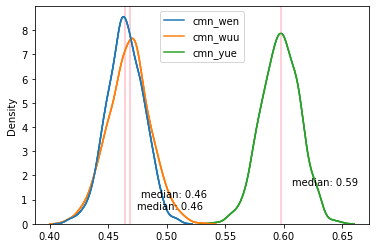

In [69]:
plot(all_cmn_df)

From their mean and median, we can see wuu and wen pair has considerately smaller values than wuu and wen with yue. On the other hand, wuu and yue shows stronger difference than wen and yue (interesting!)

Language pair: wuu, wen
mean:  0.5249712410667489 ; median:  0.5249646277252125 standard derivation:  0.017388655458476447
2u:  0.49018731680825955 - 0.5597419386421654
Language pair: wuu, yue
mean:  0.6531471039907715 ; median:  0.6530386055313151 standard derivation:  0.015203228055550421
2u:  0.6226321494202143 - 0.6834450616424159
Language pair: wen, yue
mean:  0.632161821932184 ; median:  0.6329844117007508 standard derivation:  0.015588903579356075
2u:  0.6018066045420387 - 0.6641622188594629


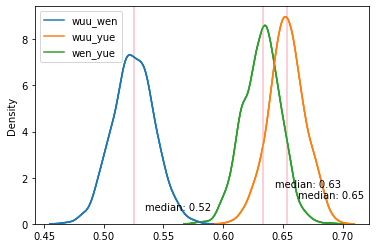

In [70]:
stack = np.stack((np.array(sample_ww),np.array(sample_wuy), np.array(sample_wey)), axis=1)
all_cmn_df = pd.DataFrame(stack, columns=["wuu_wen", "wuu_yue", "wen_yue"])
plot(all_cmn_df)